In [50]:
import lxml
from urllib import request
from lxml import etree
import pandas as pd
import numpy as np
from selenium import webdriver 

# Globals
baseurl = r'http://www.sharkattackdata.com'
headurl = baseurl + r'/place/united_states_of_america'
path_to_chrome = 'C:/Users/red7740/Downloads/chromedriver.exe'

In [51]:
# Add options arguments for Chrome webdriver
options = webdriver.ChromeOptions() # Assign a var name to options object
options.add_argument('headless') # Prevent chrome from opening a GUI when called 

In [52]:
def getHTML(url, browser):
    '''
    Returns inner html after JS executes
    '''
    # Load the page and scrape for data 
    browser.get(url)
    innerHTML = browser.execute_script("return document.body.innerHTML") #returns the inner HTML as a string
    return innerHTML

In [60]:
# Get the general shark attack data
# assign Chrome webdriver object to variable name 
browser = webdriver.Chrome(executable_path=path_to_chrome,chrome_options=options)
# Call our function to get the html string
rootHTML = getHTML(headurl,browser)
#close the browser
browser.close()

# Parse html string
myETree = lxml.etree.HTML(rootHTML)
# xpath for data
heads = myETree.xpath('//thead/tr/th') #header names
attacks = myETree.xpath('//tbody/tr/td') #root-level attack data
links = myETree.xpath('//tbody/tr/td/a/@href') #click through links for detail data

#convert column names to list
headings=[]
for h in heads:
    headings.append(h.text)

#convert data to list
data=[]
for a in attacks:
    data.append(a.text)

#convert links to list
links = list(links)


In [61]:
# There is an empty value at the end of the headings list
# where the url for details resides. We aren't keeping the
# url in the data set, but need to name it to delete it later
headings.pop() 
headings.append('url')

In [62]:
# Massage Data into a pandas dataframe
#get some numbers...
ncols = len(headings) # length of headings list
nrows = int(len(data)/len(headings)) # data is a 1-d list, so length of list / number of columns 

#Start with data -> numpy array -> reshape -> dataframe
data = np.array(data) #list-> numpy array
data = data.reshape(nrows,ncols)# reshape array using vals from above
data = pd.DataFrame(data) #np.array -> dataframe

In [63]:
# Assign column names
data.columns = headings
# delete that url column .. we stored it separately already
del data['url']
#General data on us shark attacks
data.head()

,Date,Area,Location,Activity,Incident Type,Fatal?
0,Unknown,Hawaii,Puna,None,Unprovoked,Non-fatal
1,Unknown,North Carolina,Somewhere between Hatteras and Beaufort,Swimming,Unprovoked,Non-fatal
2,Unknown,Florida,"Gadsden Point, Tampa Bay",Fishing,Unprovoked,Non-fatal
3,Unknown,Florida,"Palm Beach, Palm Beach County",Standing,Unprovoked,Non-fatal
4,Unknown,California,"Capistrano, Orange County",None,Unprovoked,Non-fatal


In [64]:
#loop through detail urls and grab data
detail_data = [] # data
detail_headers = [] # column names
count = 0 #counter for loop progress to display

browser = webdriver.Chrome(executable_path=path_to_chrome,chrome_options=options)#open the browser again...

for url in links:      
    # Parse html string
    myETree = lxml.etree.HTML(getHTML(baseurl+url,browser))
    # xpath for data
    dat = myETree.xpath('//tbody/tr/td')
    
    #convert data to list
    details=[]
    for d in dat:
        details.append(d.text)
        
    #append details of each record to data list
    detail_data.append(details)
    
    # First time through loop - grab headers
    if count == 0: #change count var to boolean if count-print removed
        # xpath for data
        dat = myETree.xpath('//tbody/tr/th')
        #convert data to list
        detail_headers=[]
        for d in dat:
            detail_headers.append(d.text)
            
    # print progress tracking since this takes a long time to execute - 
    # can remove print for minor performance improvement without status tracking
    count += 1
    if (count % 200) == 0:
        print("Status: record " + str(count) + " completed. " + str(nrows - count) + " remaining")
        
# details -> dataframe     
detail_data = pd.DataFrame(detail_data)
detail_data.columns = detail_headers

browser.close() # Close the browser... Finally done with it!


Status: record 200 completed. 1457 remaining
Status: record 400 completed. 1257 remaining
Status: record 600 completed. 1057 remaining
Status: record 800 completed. 857 remaining
Status: record 1000 completed. 657 remaining
Status: record 1200 completed. 457 remaining
Status: record 1400 completed. 257 remaining
Status: record 1600 completed. 57 remaining


In [65]:
#Here is the detail-level data for each of the records in the general data
detail_data.head()

,GSAF Case #,Date,Country,Area,Location,Activity,Name,Sex,Age,Injury,Time,Species,Investigator or Source,Fatal?,Incident Type
0,ND.0010,Unknown,None,None,Puna,None,A chiefess,Female,None,Ankle bitten,None,None,Captain W. Young,Not fatal,Unprovoked
1,ND.0014,Unknown,None,None,Somewhere between Hatteras and Beaufort,Swimming,"""youthful male""",Male,None,"""Lost leg""",None,None,"C. Creswell, GSAF; Wilmington Star, 7/17/1916",Not fatal,Unprovoked
2,ND.0019,Unknown,None,None,"Gadsden Point, Tampa Bay",Fishing,James Kelley,Male,None,2-inch lacerations,None,None,"T. Helm, p.219",Not fatal,Unprovoked
3,ND.0056,Unknown,None,None,"Palm Beach, Palm Beach County",Standing,Horton Chase,Male,None,Abrasions & bruises hip to ankle,None,None,"V.M. Coppleson (1956), p.255; R.F. Hutton",Not fatal,Unprovoked
4,ND.0060,Unknown,None,None,"Capistrano, Orange County",None,girl,Female,None,Leg injured,None,"White shark, 1,900-lb","B. Walton, Sun (San Bernardino), 6/19/1959",Not fatal,Unprovoked


In [66]:
#This was predetermined to be true for all records, so put in a form we will use later
detail_data.loc[:,'Country'] = 'USA' 
# Remove the duplicate columns from the detail set
detail_data_temp = detail_data[['GSAF Case #','Name','Sex','Age','Injury','Time','Species','Investigator or Source','Country']]
# Here is the final detail data
detail_data_temp.head()

,GSAF Case #,Name,Sex,Age,Injury,Time,Species,Investigator or Source,Country
0,ND.0010,A chiefess,Female,None,Ankle bitten,None,None,Captain W. Young,USA
1,ND.0014,"""youthful male""",Male,None,"""Lost leg""",None,None,"C. Creswell, GSAF; Wilmington Star, 7/17/1916",USA
2,ND.0019,James Kelley,Male,None,2-inch lacerations,None,None,"T. Helm, p.219",USA
3,ND.0056,Horton Chase,Male,None,Abrasions & bruises hip to ankle,None,None,"V.M. Coppleson (1956), p.255; R.F. Hutton",USA
4,ND.0060,girl,Female,None,Leg injured,None,"White shark, 1,900-lb","B. Walton, Sun (San Bernardino), 6/19/1959",USA


In [67]:
# Merge the details onto the general data
# This is the final set from the data collection stage
shark_attack_data = pd.concat([data, detail_data_temp], axis=1) 
# Concat is on index, since we know we have the same number of 
# records for each set and that they are in the same order

In [68]:
#Double Check that the data is in the form we want
shark_attack_data.head()

,Date,Area,Location,Activity,Incident Type,Fatal?,GSAF Case #,Name,Sex,Age,Injury,Time,Species,Investigator or Source,Country
0,Unknown,Hawaii,Puna,None,Unprovoked,Non-fatal,ND.0010,A chiefess,Female,None,Ankle bitten,None,None,Captain W. Young,USA
1,Unknown,North Carolina,Somewhere between Hatteras and Beaufort,Swimming,Unprovoked,Non-fatal,ND.0014,"""youthful male""",Male,None,"""Lost leg""",None,None,"C. Creswell, GSAF; Wilmington Star, 7/17/1916",USA
2,Unknown,Florida,"Gadsden Point, Tampa Bay",Fishing,Unprovoked,Non-fatal,ND.0019,James Kelley,Male,None,2-inch lacerations,None,None,"T. Helm, p.219",USA
3,Unknown,Florida,"Palm Beach, Palm Beach County",Standing,Unprovoked,Non-fatal,ND.0056,Horton Chase,Male,None,Abrasions & bruises hip to ankle,None,None,"V.M. Coppleson (1956), p.255; R.F. Hutton",USA
4,Unknown,California,"Capistrano, Orange County",None,Unprovoked,Non-fatal,ND.0060,girl,Female,None,Leg injured,None,"White shark, 1,900-lb","B. Walton, Sun (San Bernardino), 6/19/1959",USA


In [69]:
#Export the full data set to external storage for later analysis
shark_attack_data.to_csv('./attackdata.csv')

In [73]:
# Were any of the attacks provoked? it turns out... no 
shark_attack_data['Incident Type'].value_counts().to_dict()

{'Unprovoked': 1657}

In [80]:
# Make an age set
shark_attack_data.Age.fillna(0,inplace=True) #NaN vals -> 0
# ages is our new condensed dataframe object for ages and freq. counts
ages = pd.DataFrame(shark_attack_data['Age'].value_counts()).reset_index()
#name columns
ages.columns = ['Age','Count']
#remove unknown age from ages df
#and save separately for later
unknownage = ages.iloc[0]
ages = ages[1:] 
#sort ages to plot and re-zero the index...
ages = ages.sort_values('Age').reset_index()
del ages['index']


In [95]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [86]:
#Some regular expressions to clean up the data in the age column
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(.{2})or.*', r'\1')
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(.{2})&.*', r'\1')
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(.{2})\'s', r'\1')
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(.{2})s', r'\1')
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(6)[^0-9]', r'\1')
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'(young)', r'5') # hack to bin as child
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'teen', r'15') # hack to bin as teen
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'Teen', r'15') # hack to bin as teen
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'Elderly', r'80') #hack to bin as senior
shark_attack_data['Age'] = shark_attack_data['Age'].str.replace(r'mid-30', r'35') #hack to bin as senior
shark_attack_data.Age.fillna(0,inplace=True) #NaN vals -> 0

# Some values were already binned with a count, so separate them
cats = ages[80:]
ages = ages[:80]

#Bin the rest of the records in the ages set
#add a cin column to the data set
shark_attack_data['agebin'] = ''

#dictionary to hold binned data
age_bins = {'Child':0,'Teen':0,'Young Adult':0,'Adult':0,'Seniors':0}

for i in range(len(shark_attack_data['Age'])):
    
    if int(shark_attack_data['Age'][i]) <= 13: 
        age_bins['Child'] += 1
        shark_attack_data['agebin'][i] = 'Child'
    elif int(shark_attack_data['Age'][i]) <= 18:
        age_bins['Teen'] += 1
        shark_attack_data['agebin'][i] = 'Teen'
    elif int(shark_attack_data['Age'][i]) <= 25:
        age_bins['Young Adult'] += 1
        shark_attack_data['agebin'][i] = 'Young Adult'
    elif int(shark_attack_data['Age'][i]) <= 65:
        age_bins['Adult'] += 1
        shark_attack_data['agebin'][i] = 'Adult'
    else:
        age_bins['Seniors'] += 1
        shark_attack_data['agebin'][i] = 'Seniors'


In [90]:
shark_attack_data['agebin'].value_counts()

Child          626
Adult          466
Teen           274
Young Adult    273
Seniors         18
Name: agebin, dtype: int64

In [91]:
age_bins['Unknown'] = unknownage['Count']

#hack for categorical data cleanup -- can't automate
age_bins['Child'] += 1
age_bins['Teen'] += 7
age_bins['Young Adult'] += 1
age_bins['Seniors'] += 1

age_sum = sum(age_bins.values())

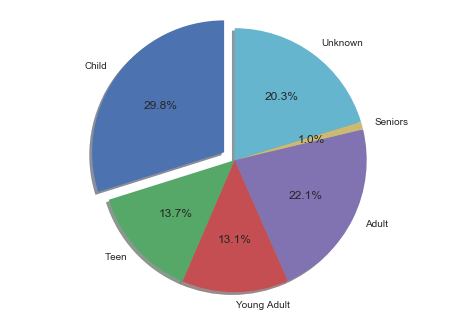

In [97]:
fig = plt.figure(figsize=(11,11))
a_vals = [a / age_sum for a in age_bins.values()]
explode = (0.1, 0, 0, 0, 0, 0)  # only "explode" the 1st slice (i.e. 'Child')
alabels = list(age_bins.keys())
fig1, ax1 = plt.subplots()
ax1.pie(a_vals, explode=explode, labels=alabels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [98]:
#make Activity set
by_activity = data['Activity'].value_counts().to_dict()

In [99]:
data.Activity.fillna('',inplace=True) #NaN vals -> 0

In [108]:
#bin the incident types. We use snippets of words to catch misspellings
#it works surprisingly well to clean up the activity column
shark_attack_data['ActBin'] = ''
for i in range(len(shark_attack_data['Activity'])):
    f = shark_attack_data['Activity'][i]
    if 'Swim' in str(f) or 'Swim' in str(f) or 'Escaping' in str(f) or 'Tread' in str(f):
        shark_attack_data['ActBin'][i] = 'Swimming'
    elif 'surf' in str(f) or 'Surf' in str(f) or 'board' in str(f) or 'Board' in str(f):
        shark_attack_data['ActBin'][i] = 'Surfing'
    elif 'Bath' in str(f) or 'bath' in str(f) or 'wad' in str(f) or 'Wad' in str(f) or 'walk' in str(f) or 'Walk' in str(f):
        shark_attack_data['ActBin'][i] = 'Bathing'
    elif 'div' in str(f) or 'ork' in str(f) or 'Div' in str(f):
        shark_attack_data['ActBin'][i] = 'Diving' 
    elif 'fish' in str(f) or 'Fish' in str(f) or 'crab' in str(f) or 'Crab' in str(f) or 'net' in str(f) or 'Net' in str(f) or 'Clam' in str(f):
        shark_attack_data['ActBin'][i] = 'Fishing'
    elif 'boat' in str(f) or 'Boat' in str(f) or 'Sail' in str(f) or 'Vessel' in str(f) or 'Canoe' in str(f) or 'Kayak' in str(f) or 'overboard' in str(f) or 'capsized' in str(f) or 'Washed' in str(f):
        shark_attack_data['ActBin'][i] = 'Boating'
    elif 'Standing' in str(f):
        shark_attack_data['ActBin'][i] = 'Standing'
    elif 'Float' in str(f):
        shark_attack_data['ActBin'][i] = 'Floating'
    elif str(f) == '':
        shark_attack_data['ActBin'][i] = 'Unknown'
    else:
        shark_attack_data['ActBin'][i] = 'Other'

In [109]:
interesting_activities = shark_attack_data[shark_attack_data['ActBin']=='Other']['Activity']
interesting_activities.value_counts().to_dict()

{'3 men & 2 boys picked up wearing life jackets and with inner tube': 1,
 'Adrift in a life jacket': 1,
 'Attempting to rescue a shark': 1,
 'Attempting to rescue woman seized by shark': 1,
 "Crouching in 2' of water": 1,
 'Dangling feet in the water': 1,
 'Hunting turtle': 1,
 'In waist-deep water': 1,
 'Jet skiing': 2,
 'Jumped into the water': 2,
 'Jumped off rocks into white water': 1,
 'Jumping': 4,
 'Jumping in the waves': 1,
 'Kneeling in the water': 1,
 'Knocked into the water': 1,
 "Lying prone in 2' of water": 1,
 'On a float': 1,
 'Photographing the shark': 1,
 'Plane crashed in water, men in life raft': 1,
 'Playing': 7,
 'Playing / jumping': 1,
 'Playing in knee-deep water': 1,
 'Playing in the water': 1,
 'Playing on a sandbar': 1,
 'Playing soccer in the water': 1,
 'Playing with a frisbee in the shallows': 1,
 'Pulling raft out to ride to shore': 1,
 'Riding floatation device': 1,
 'Rolled off raft': 1,
 'Shark tagging': 1,
 "Sitting in 3' of water": 1,
 'Sitting in the

In [110]:
# Take it a step further...
# Look at Activity distribution between fatal and not fatal
fatal_by_activity = shark_attack_data[['Fatal?','ActBin']]
isfat = fatal_by_activity[fatal_by_activity['Fatal?'] == 'Fatal']['ActBin']
notfat = fatal_by_activity[fatal_by_activity['Fatal?'] != 'Fatal']['ActBin']

fat_bin_counts = isfat.value_counts().to_dict()
not_fat_bin_counts  = notfat.value_counts().to_dict()

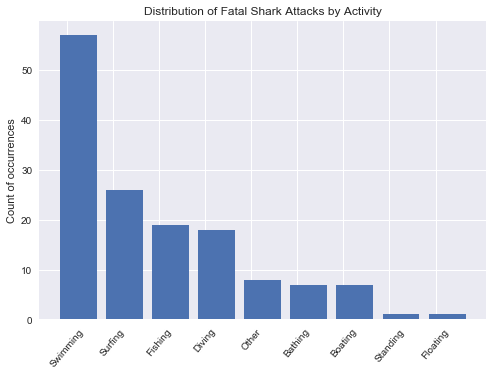

In [113]:
xvals = list(range(len(fat_bin_counts)))
labels = list(fat_bin_counts.keys())

plt.bar(xvals,fat_bin_counts.values())
xticks_pos = [x - .25 for x in xvals]
plt.xticks(xticks_pos, labels, rotation='50')
plt.title('Distribution of Fatal Shark Attacks by Activity')
plt.ylabel('Count of occurrences')

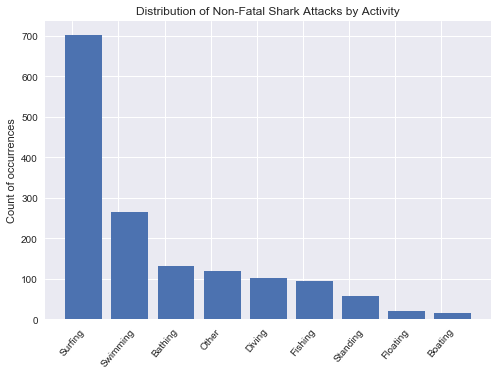

In [114]:
xvals = list(range(len(not_fat_bin_counts)))
labels = list(not_fat_bin_counts.keys())

plt.bar(xvals,not_fat_bin_counts.values())
xticks_pos = [x - .25 for x in xvals]
plt.xticks(xticks_pos, labels, rotation='50')
plt.title('Distribution of Non-Fatal Shark Attacks by Activity')
plt.ylabel('Count of occurrences')

In [115]:
#Look at distribution of attacks by age and activity

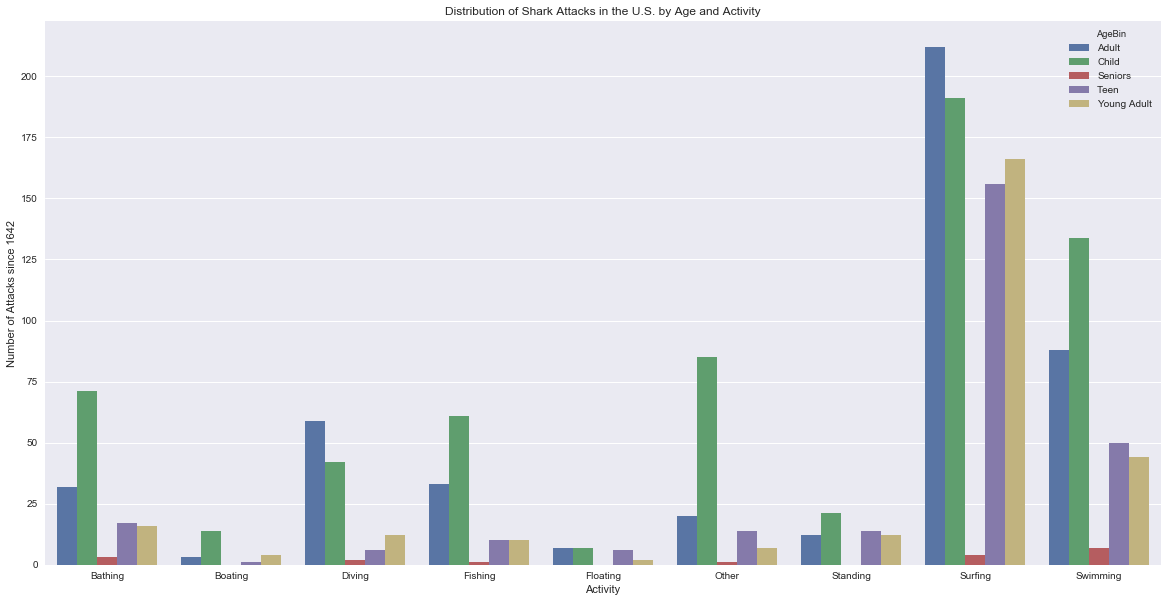

In [118]:
fig = plt.figure(figsize=(20,10))
test = shark_attack_data[['ActBin','agebin']].groupby(["ActBin",'agebin']).size()
test = pd.DataFrame(test)
test = test.reset_index()
test.columns = ['ActBin', 'AgeBin','Count']
actlabels=['Boating','Fishing','Water Sports','Swimming','Other']
sns.barplot(x="ActBin", y="Count", hue="AgeBin", data=test);
plt.title("Distribution of Shark Attacks in the U.S. by Age and Activity")
plt.ylabel("Number of Attacks since 1642")
plt.xlabel("Activity")


In [154]:
#Make a by-gender set
by_gender = pd.DataFrame(shark_attack_data[['Sex','Fatal?']].groupby(['Sex','Fatal?']).size()).reset_index()
by_gender.columns = ['Sex','Fatal?','Count']
f_ratio = by_gender.iloc[0][2] / by_gender.iloc[1][2]
m_ratio = by_gender.iloc[2][2] / by_gender.iloc[3][2]
print('A female shark attack victim has a',f_ratio,'chance of dying from the attack') 
print('A male shark attack victim has a',m_ratio,'chance of dying from the attack') 

A female shark attack victim has a 0.042471042471 chance of dying from the attack
A male shark attack victim has a 0.107641741988 chance of dying from the attack


In [155]:
areas = shark_attack_data['Area'].value_counts().to_dict()

In [156]:
test = shark_attack_data[['Area','Fatal?']].groupby(["Area",'Fatal?']).size()
test = pd.DataFrame(test)
test = test.reset_index()
test.columns = ['Area', 'isFatal','Count']